In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_google_genai import ChatGoogleGenerativeAI

google_api_key=os.environ['Gemini_API_key']


In [2]:

model=ChatGoogleGenerativeAI(model='gemini-1.5-flash',google_api_key=google_api_key)
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


## retriever

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

c:\Users\judirispah\anaconda3\envs\agent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [4]:

from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFLoader


In [5]:
loader=PyPDFLoader('SOFTWARE TESTING.pdf')
docs=loader.load()
docs


[Document(metadata={'producer': '', 'creator': 'WPS Writer', 'creationdate': '2022-08-07T12:51:01+07:21', 'author': 'Lenovo', 'comments': '', 'company': '', 'keywords': '', 'moddate': '2022-08-07T12:51:01+07:21', 'sourcemodified': "D:20220807125101+07'21'", 'subject': '', 'title': '', 'trapped': '/False', 'source': 'SOFTWARE TESTING.pdf', 'total_pages': 83, 'page': 0, 'page_label': '1'}, page_content='1\nSOFTWARE TESTING\nMANUAL TESTING\n1. what is software testing? All definitions\n2. what is difference between manual testing and automation testing?\n3. what is SDLC explain SDLC?\n4. models of SDLC?\n5. why testing is important?\n6. explain white box testing black box testing Grey box testing?\n7. explain functional testing, integration testing, system testing?\n8. explain retesting and regression testing with example?\n9. what is scenario explain types of scenario?\n10. give example for positive scenario and negative scenario for one object and for one\napplication?\n11. tell about d

In [6]:

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_string=[doc.page_content for doc in new_docs]

In [7]:
index = faiss.IndexFlatL2(384)
vectordb = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)
retriever = vectordb.as_retriever(search_kwargs={"k": 3})


# pydantic class

In [8]:
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

import operator

from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser



In [9]:
class TopicSelectionParser(BaseModel):#structure of output of supervisor
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description="reasoning behind topic selection")

In [10]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

# dict format input with list as value 

In [11]:
class Agentstate(TypedDict):
    message: Annotated[Sequence[BaseMessage],operator.add]

In [12]:
def supervisor(state:Agentstate):
    question=state["message"][-1] # recent msg from user query
    print('question',question)

    template="""
    Your task is to classify the given user query into one of the following categories:
     [software testing ,Not Related,today,now,live,breaking,news,today,date]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"], #user query
        partial_variables={"format_instructions": parser.get_format_instructions()}# format of pydantic output
        )

    chain=prompt | model| parser
    response = chain.invoke({"question":question})
    print("Parsed response:", response)
    
    return {"message": [response.Topic]}

In [13]:
def router(state:Agentstate):
    print("-> ROUTER ->")
    last_message=state['message'][-1]
    if "software testing" in last_message.lower():
        return "RAG CALL"
    if  last_message.lower() in ["today", "latest", "current", "breaking", "news", "live", "now","date"] :
        return "WEB CALL"
    else:
        return "LLM CALL"

In [14]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [15]:

# RAG Function
def function_1(state:Agentstate):
    print("-> RAG Call ->")
    
    question = state["message"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the 
        following pieces of retrieved context to
         answer the question. If you don't know the 
         answer, just say that you don't know. Use 
         three sentences maximum and keep the answer
          concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"message": [result]}


In [16]:
def function_2(state:Agentstate):
    print("-> LLM Call ->")
    question = state["message"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"message": [response.content]}

In [120]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.agents import initialize_agent, AgentType
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode


os.environ["TAVILY_API_KEY"] = "your-api-key"

def function_3(state:Agentstate):
    print("-> WEB SEARCH ->")
    question = state["message"][0]

    #search=DuckDuckGoSearchRun(name="search")
    search2 = TavilySearch()

    tools = [search2]
    #agent = initialize_agent(
    #tools=tools,
    ##llm=model,
    #agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    #verbose=True)
    toolnode = ToolNode(tools)
    ll_with_tool=model.bind_tools(toolnode)
    response=toolnode.invoke({"messages": question})
    print(response)
    #for msg in response["messages"]:
        #if isinstance(msg,AIMessage):
            #print(type(msg.content))
    return {'message':[response.content]}

In [121]:
state={'message':["what is the treding news in tamil nadu"]}

In [122]:
function_3(state)

convert_to_genai_function_declarations expects a Sequence and not a single tool.


-> WEB SEARCH ->


ValueError: Unsupported tool type tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'tavily_search': TavilySearch(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}, tool_to_state_args={'tavily_search': {}}, tool_to_store_arg={'tavily_search': None}, handle_tool_errors=True, messages_key='messages')

In [75]:
def validation(state:Agentstate):
    print(state)
    return {'message':[state['message'][-1]]}

In [119]:
validation({"message":['0/0']})

{'message': ['0/0']}


{'message': ['0/0']}

In [91]:
def validatiton_router(state:Agentstate):
    print(state)
    print('-> VALIDATION <-')
    result=state['message'][0]
    print(result)
    print('hi2')
    failure_phrases = [
        "i don't know",
        "unable to answer",
        "cannot access",
        "not functioning",
        "error 401",
        "invalid api key",
        "visit a news site",
        "no internet access",
        ' ',
    ]
    if any(i in result.lower() for i in failure_phrases):
        print("INVALIDATION_CALL")
        return "INVALIDATION_CALL"
    else:
        print("VALIDATION_CALL")
        return "VALIDATION_CALL"

In [92]:
validatiton_router({"message":['hi']})

{'message': ['hi']}
-> VALIDATION <-
hi
hi2
VALIDATION_CALL


'VALIDATION_CALL'

In [93]:
def output(state:Agentstate):
    print('-> FINAL <-')
    print(state['message'][-1])

In [97]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(Agentstate)
workflow.add_node("supervisor",supervisor)
workflow.add_node("rag",function_1)
workflow.add_node('llm',function_2)
workflow.add_node('web',function_3)
workflow.add_node('validation',validation)
workflow.add_node('final',output)



workflow.set_entry_point("supervisor")

workflow.add_conditional_edges(
    "supervisor",
    router,{
        "RAG CALL":'rag',
        "LLM CALL":'llm',
        "WEB CALL":'web'
    }
)

workflow.add_edge("rag",'validation')
workflow.add_edge("llm",'validation')
workflow.add_edge("web",'validation')


workflow.add_edge("final",END)




workflow.add_conditional_edges(
    "validation",
    validatiton_router,{
        "VALIDATION_CALL":"final",
        "INVALIDATION_CALL":'supervisor',
    })


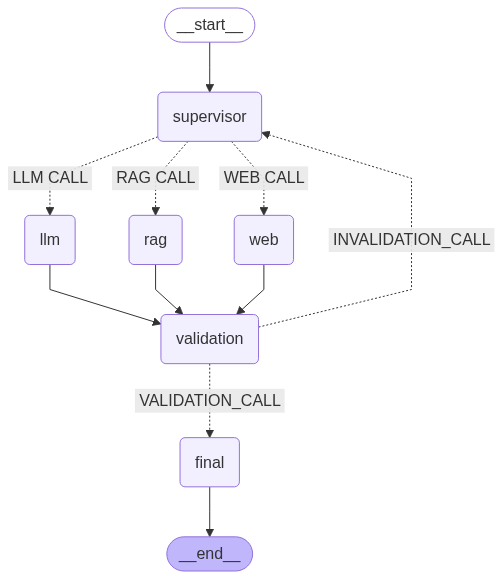

In [98]:
app=workflow.compile()
app

In [99]:
state={'message':['what is software testing?']}
app.invoke(state)

question what is software testing?


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
]